In [1]:
<a target="_blank" href="https://colab.research.google.com/github/roshkjr/pdbeccdutils_tutorials/blob/main/spring_school_2024/pdbeccdutils_intro.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

SyntaxError: invalid syntax (2474296534.py, line 1)

# Introduction

PDBe CCDUtils is an open-source python package for processing and analyzing small molecules in the PDB. Small-molecule data in the PDB is available as [Chemical Component Dictionary (CCD)](http://www.wwpdb.org/data/ccd) or [Biologically Interesting Molecule reference Dictioanry (BIRD)](http://www.wwpdb.org/data/bird) in PDBX/mmCIF format. PDBe CCDUtils provides streamlined access to all metadata of small molecules in the PDB and offers a set of convenient methods to compute various properties of small molecules using RDKIt such as 

* [Physicochemical properties](#accessing-properties-of-CCD)
* [Matching common fragments and scaffolds](#finding-fragments-and-scaffolds)
* [Mapping to small-molecule databases using UniChem](#fetching-external-mappings-to-other-databases)
* 2D depictions
 

PDBe CCDUtils also provides methods for identifying all the Covalently Linked Chemical components (CLC) in a macromolecular structure and calculating similarity among small molecules using [PARITY method](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5890617/) 

## Installation of dependencies

In [ ]:
%pip install rdkit

In [ ]:
%pip install pdbeccdutils

In [ ]:
import os
import requests
from enum import Enum
from pdbeccdutils.core import ccd_reader
from pdbeccdutils.core.component import Component

In [ ]:
PDBECHEM_URL = "https://ftp.ebi.ac.uk/pub/databases/msd/pdbechem_v2"
ENTRY_URL = "https://ftp.ebi.ac.uk/pub/databases/msd/updated_mmcif/all"

class ligandType(Enum):
    CCD = "ccd"
    PRD = "prd"
    CLC = "clc"


def get_ligand_cif(ligand_id: str, ligand_type: ligandType) -> str:
    """
    Downloads and writes ligand CIF from PDBe FTP to a file
    and returns the path

    Args:
        ligand_id: ID of the ligand
        ligand_type: Type of ligand
    
    Returns:
        The path to cif file of ligand
    """
    match ligand_type.value:
        case "ccd":
            ligand_dir = os.path.join("ccd", ligand_id[0], ligand_id)
        case "prd":
            ligand_dir = os.path.join("prd", ligand_id[-1],ligand_id)
        case "clc":
            ligand_dir = os.path.join("clc", ligand_id[-1],ligand_id)
    try:
        ligand_cif_path = os.path.join(PDBECHEM_URL, ligand_dir, f"{ligand_id}.cif")
        response = requests.get(ligand_cif_path)
        assert response.status_code == 200
        ligand_cif_file = os.path.join(os.getcwd(), f"{ligand_id}.cif")
        with open(ligand_cif_file, "wb") as fh:
            fh.write(response.content)

        return ligand_cif_file
    except  AssertionError:
        print(f"Couldn't find the file. Check if {ligand_id} & {ligand_type} are valid, if so try again")


## Reading small molecule data

In [2]:
hem_cif = get_ligand_cif("HEM", ligandType.CCD)
hem =  ccd_reader.read_pdb_cif_file(hem_cif)

In [3]:
hem

CCDReaderResult(warnings=[], errors=[], component=<pdbeccdutils.core.component.Component object at 0x7fb7883920e0>, sanitized=True)

CCDReaderResult contains a component object - the core structural representation of small-molecules in PDBe CCDUtils. Component is a wrapper around rdkit.Chem.rdchem.Mol object providing most of its functionality and access metada data from CCD file. 

In [3]:
hem_component = hem.component

### Accessing properties of CCD

Properties in the CCD file and physicochemical properties generated by RDKit can be accessed using attributes of the Component object

In [4]:
print(f"""
id: {hem_component.id}
name: {hem_component.name}
formula: {hem_component.formula}
inchi: {hem_component.inchi}
inchikey: {hem_component.inchikey}
release status: {hem_component.pdbx_release_status.name}
modified_date: {hem_component.modified_date}
""")


id: HEM
name: PROTOPORPHYRIN IX CONTAINING FE
formula: C34 H32 Fe N4 O4
inchi: InChI=1S/C34H34N4O4.Fe/c1-7-21-17(3)25-13-26-19(5)23(9-11-33(39)40)31(37-26)16-32-24(10-12-34(41)42)20(6)28(38-32)15-30-22(8-2)18(4)27(36-30)14-29(21)35-25;/h7-8,13-16H,1-2,9-12H2,3-6H3,(H4,35,36,37,38,39,40,41,42);/q;+2/p-2/b25-13-,26-13-,27-14-,28-15-,29-14-,30-15-,31-16-,32-16-;
inchikey: KABFMIBPWCXCRK-RGGAHWMASA-L
release status: REL
modified_date: 2020-06-17



In [5]:
hem_component.descriptors

[Descriptor(type='SMILES', program='ACDLabs', program_version='12.01', value='C=1c3c(c(c4C=C5C(=C(C=6C=C7C(=C(C8=CC=2C(=C(C=1N=2[Fe](n34)(N5=6)N78)CCC(=O)O)C)\\C=C)C)\\C=C)C)C)CCC(=O)O'),
 Descriptor(type='InChI', program='InChI', program_version='1.03', value='InChI=1S/C34H34N4O4.Fe/c1-7-21-17(3)25-13-26-19(5)23(9-11-33(39)40)31(37-26)16-32-24(10-12-34(41)42)20(6)28(38-32)15-30-22(8-2)18(4)27(36-30)14-29(21)35-25;/h7-8,13-16H,1-2,9-12H2,3-6H3,(H4,35,36,37,38,39,40,41,42);/q;+2/p-2/b25-13-,26-13-,27-14-,28-15-,29-14-,30-15-,31-16-,32-16-;'),
 Descriptor(type='InChIKey', program='InChI', program_version='1.03', value='KABFMIBPWCXCRK-RGGAHWMASA-L'),
 Descriptor(type='SMILES_CANONICAL', program='CACTVS', program_version='3.385', value='CC1=C(CCC(O)=O)C2=Cc3n4[Fe]5|6|N2=C1C=c7n5c(=CC8=N|6C(=Cc4c(C)c3CCC(O)=O)C(=C8C=C)C)c(C)c7C=C'),
 Descriptor(type='SMILES', program='CACTVS', program_version='3.385', value='CC1=C(CCC(O)=O)C2=Cc3n4[Fe]5|6|N2=C1C=c7n5c(=CC8=N|6C(=Cc4c(C)c3CCC(O)=O)C(=C8C=C)C

In [16]:
hem_component.physchem_properties

{'exactmw': 616.177293004001,
 'amw': 616.4990000000015,
 'lipinskiHBA': 8.0,
 'lipinskiHBD': 2.0,
 'NumRotatableBonds': 12.0,
 'NumHBD': 2.0,
 'NumHBA': 8.0,
 'NumHeavyAtoms': 43.0,
 'NumAtoms': 75.0,
 'NumHeteroatoms': 9.0,
 'NumAmideBonds': 0.0,
 'FractionCSP3': 0.23529411764705882,
 'NumRings': 6.0,
 'NumAromaticRings': 2.0,
 'NumAliphaticRings': 4.0,
 'NumSaturatedRings': 0.0,
 'NumHeterocycles': 6.0,
 'NumAromaticHeterocycles': 2.0,
 'NumSaturatedHeterocycles': 0.0,
 'NumAliphaticHeterocycles': 4.0,
 'NumSpiroAtoms': 0.0,
 'NumBridgeheadAtoms': 6.0,
 'NumAtomStereoCenters': 1.0,
 'NumUnspecifiedAtomStereoCenters': 0.0,
 'labuteASA': 296.33725284003606,
 'tpsa': 96.26000000000002,
 'CrippenClogP': 6.210060000000007,
 'CrippenMR': 165.27259999999967,
 'chi0v': 21.879585517566603,
 'chi1v': 13.71303192500862,
 'chi2v': 11.67144422171997,
 'chi3v': 11.67144422171997,
 'chi4v': 10.931337280412357,
 'chi0n': 52.775400934448555,
 'chi1n': 27.554303075888956,
 'chi2n': 7.046175792189254,

### Fetching external mappings to other databases

In [18]:
external_mappings = hem_component.fetch_external_mappings(all_mappings=True)
external_mappings

### Finding fragments and scaffolds

PDBe CCDUtils supports search for fragments present in a small molecule from a library of fragments. The fragment library present in PDBe CCDUtils contains 2158 fragments which were manually currated at PDBe and collaborating resources (ENAMINE, DSI). Should you wish to check all the fragments, please check [fragment_library.tsv](https://github.com/PDBeurope/ccdutils/blob/master/pdbeccdutils/data/fragment_library.tsv) file.

In [6]:
from pdbeccdutils.core.fragment_library import FragmentLibrary
from rdkit.Chem import Draw

In [7]:
fragment_library = FragmentLibrary()

In [8]:
fragment_matches = hem_component.library_search(fragment_library)
print(f"No of fragments found: {len(fragment_matches)}")

No of fragments found: 2


In [9]:
fragment_matches

[SubstructureMapping(name='porphin-like', mol=<rdkit.Chem.rdchem.Mol object at 0x7fdf80da6810>, source='PDBe', mappings=((5, 6, 7, 1, 14, 39, 17, 16, 15, 2, 21, 40, 24, 3, 28, 41, 31, 0, 4, 38, 30, 29, 23, 22),)),
 SubstructureMapping(name='pyrrole', mol=<rdkit.Chem.rdchem.Mol object at 0x7fdf80da6f80>, source='PDBe', mappings=((4, 5, 6, 7, 38), (21, 22, 23, 24, 40)))]

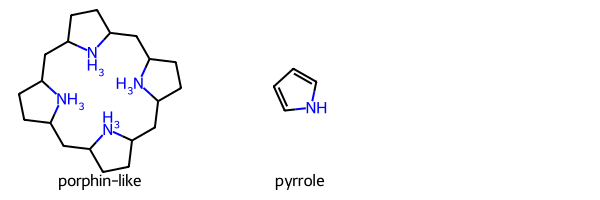

In [10]:
fragment_mols = [fragment.mol for fragment in hem_component.fragments]
img = Draw.MolsToGridImage(fragment_mols, legends = [fragment.name for fragment in hem_component.fragments])
img

CCD files contains Model conformer (coordiantes present in the PDB entry from which the definition of the CCD was created) and Ideal conformer (Idealized coordiantes generated using OpenEye Toolkit). Properties of both Model and Ideal conformers can be accessed from the mol attribute of component object. 

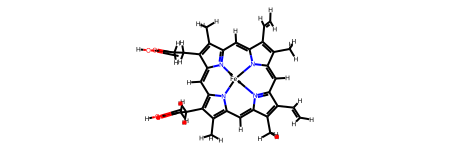

In [4]:
hem.component.mol

### Scaffolds

PDBe CCDUtils supports identification of scaffolds of small moelcules in PDB using the RDKit functionality. Currently it supports three types of scaffolding methods
* MurckoScaffold
* MurckoScaffoldGeneric
* BRICS

In [ ]:
from pdbeccdutils.core.models import ScaffoldingMethod

In [ ]:
murcko_scaffolds = hem_component.get_scaffolds(scaffolding_method = ScaffoldingMethod.MurckoScaffold)
generic_murcko_scaffolds = hem_component.get_scaffolds(scaffolding_method = ScaffoldingMethod.MurckoGeneric)
brics_scaffolds = hem_component.get_scaffolds(scaffolding_method=ScaffoldingMethod.Brics)

In [ ]:
murcko_scaffolds[0]

In [ ]:
### 2D Depictions

In [ ]:
PDBe CCDUtils uses [template-based](https://rdkit.org/docs/source/rdkit.Chem.rdDepictor.html#rdkit.Chem.rdDepictor.GenerateDepictionMatching2DStructure) and [connectivity based](https://rdkit.org/docs/source/rdkit.Chem.rdCoordGen.html) methods from RDKit to generate 2D depictions of small moelcules. Templates can either be downloaded from PubChem or provided as a path to a folder containing SDF files. A hand-curated set of [ten templates](https://github.com/PDBeurope/ccdutils/tree/master/pdbeccdutils/data/general_templates) are also provided with PDBe CCDUtils

To find the best depiction of a small molecule, a heuristic-based Depiction Penalty Score (DPS) is defined. A DPS of zero indicates a high-quality 2D depiction, while higher scores indicate lower quality.

In [ ]:
hem_component.mol

In [ ]:
hem_component.export_2d_svg("hem.svg")

In [ ]:
from pdbeccdutils.core.depictions import DepictionManager
from pdbeccdutils.utils.pubchem_downloader import PubChemDownloader

In [ ]:
pubchem_templates = os.path.join(os.getcwd(), "data", "pubchem_templates")
pubchem_downloader = PubChemDownloader(pubchem_templates)
pubchem_downloader.process_template(hem_component)

In [ ]:
depictions = DepictionManager(pubchem_templates)
depiction_result = hem_component.compute_2d(depictions)
depiction_result

In [ ]:
hem_component.mol2D

In [ ]:
### Similarity using PARITY method

In [ ]:
PDBe CCDUtils supports comparison of small moelcules based on [PARITY](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5890617/) similarity score. PARITY represents the proportion of atoms of same type residing in identical topology between two small molecules

In [ ]:
from pdbeccdutils.computations.parity_method import compare_molecules

In [ ]:
heme_acetyl_cif = get_ligand_cif("HCO", ligandType.CCD)
heme_acetyl_component = ccd_reader.read_pdb_cif_file(heme_acetyl_cif).component

In [ ]:
similarity = compare_molecules(hem_component.mol_no_h, heme_acetyl_component.mol_no_h)

In [ ]:
similarity

### Export to different formats

PDBe CCDUtils presently supports exporting of small molecule data to the following formats
* CIF
* PDB
* SDF
* CML

In [ ]:
from pdbeccdutils.core import ccd_writer

In [ ]:
ccd_writer.write_molecule("outputs/hem.sdf",
                          hem_component,
                          )

In [ ]:
ccd_writer.write_molecule("outputs/hem.pdb",
                          hem_component,
                          )